In [ ]:
import os
import cv2
import torch
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [ ]:
# Function To Load The Dataset

class CancerDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform or transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),  # scales to [0, 1]
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.image_paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = self.transform(img)
        label = self.labels[idx]
        return img, label

In [ ]:
# Loading The Dataset

import glob

dataset_dir = '/content/drive/MyDrive/Cancer_Detection/BUSI'

image_paths = []
labels = []

label_map = {'benign': 'benign', 'malignant': 'malignant'}

for label in ['benign', 'malignant']:
    folder = os.path.join(dataset_dir, label)
    files = glob.glob(os.path.join(folder, "*.png"))
    image_paths.extend(files)
    labels.extend([label] * len(files))  # Use string labels directly

In [ ]:
# Splitting The Dataset

X_train, X_test, y_train, y_test = train_test_split(
    image_paths, labels, test_size=0.25, stratify=labels, random_state=42
)

train_ds = CancerDataset(X_train, y_train)
test_ds = CancerDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Cancer_Detection/')  # Change this to match your actual path

In [ ]:
# Loading The MedViT(small) Model

import torch
from MedViT import MedViT_small

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MedViT_small(num_classes=2).to(device)

checkpoint = torch.load("/content/drive/MyDrive/Cancer Detection/MedViT_small_im1k.pth", map_location=device)

if "model" in checkpoint:
    state_dict = checkpoint["model"]
else:
    state_dict = checkpoint

# Filter out keys for the classifier head to avoid size mismatch
filtered_state_dict = {k: v for k, v in state_dict.items() if not k.startswith("proj_head.0")}

# Load weights with strict=False to allow missing keys (the head)
model.load_state_dict(filtered_state_dict, strict=False)

#model.eval()

/usr/local/lib/python3.12/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/usr/local/lib/python3.12/dist-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


initialize_weights...


_IncompatibleKeys(missing_keys=['proj_head.0.weight', 'proj_head.0.bias'], unexpected_keys=[])

In [ ]:
# Function To Extract Embeddings

def extract_embedding(model, image_tensor):
    with torch.no_grad():
        x = model.stem(image_tensor)
        for layer in model.features:
            x = layer(x)
        x = model.norm(x)
        x = model.avgpool(x)
        x = torch.flatten(x, 1)  # (B, C)
    return x

In [ ]:
# Extracting Embeddings From Training And Testing Images

from tqdm import tqdm

# Extract train embeddings
train_embeddings = []
train_labels = []

for img, label in tqdm(train_loader, desc="Embedding train set"):
    img = img.to(device)
    emb = extract_embedding(model, img)
    train_embeddings.append(emb.cpu())
    train_labels.extend(label)
train_embeddings = torch.cat(train_embeddings)
# NO tensor conversion here for train_labels because they are strings

# Extract test embeddings
test_embeddings = []
test_labels = []

for img, label in tqdm(test_loader, desc="Embedding test set"):
    img = img.to(device)
    emb = extract_embedding(model, img)
    test_embeddings.append(emb.cpu())
    test_labels.extend(label)
test_embeddings = torch.cat(test_embeddings)

Embedding test set: 100%|██████████| 6/6 [03:36<00:00, 36.03s/it]


In [ ]:
import numpy as np
from sklearn.cluster import KMeans

# Convert embeddings and labels to NumPy
train_emb_np = train_embeddings.numpy()
train_labels_np = np.array(train_labels)  # ['benign', 'malignant', ...]

# Separate embeddings by class label
cls_class0 = train_emb_np[train_labels_np == 'benign']
cls_class1 = train_emb_np[train_labels_np == 'malignant']

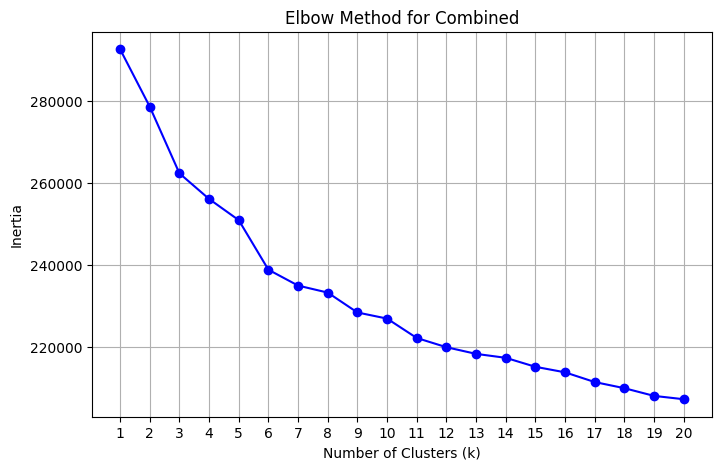

In [ ]:
# Choosing Optimal 'K' By Elbow Method

import tensorflow as tf
import matplotlib.pyplot as plt

def plot_elbow_method(cls_embeddings, max_k=15, class_name='Class'):
    inertias = []
    K_range = range(1, max_k + 1)

    for k in K_range:
        kmeans = KMeans(n_clusters=k, n_init='auto', random_state=42)
        kmeans.fit(cls_embeddings)
        inertias.append(kmeans.inertia_)

    plt.figure(figsize=(8, 5))
    plt.plot(K_range, inertias, 'bo-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.title(f'Elbow Method for {class_name}')
    plt.xticks(K_range)
    plt.grid(True)
    plt.show()


# Combine benign and malignant CLS embeddings
cls_combined = tf.concat([cls_class0, cls_class1], axis=0)

# Plot elbow method for combined classes
plot_elbow_method(cls_combined.numpy(), max_k=20, class_name='Combined')

In [ ]:
# Assigning Cluster Labels To The Training Images

from sklearn.cluster import KMeans

k = 12

# Apply KMeans to benign class
kmeans_benign = KMeans(n_clusters=k, n_init='auto', random_state=42)
kmeans_benign.fit(cls_class0)
labels_benign = kmeans_benign.labels_

# Apply KMeans to malignant class
kmeans_malignant = KMeans(n_clusters=k, n_init='auto', random_state=42)
kmeans_malignant.fit(cls_class1)
labels_malignant = kmeans_malignant.labels_

print("Benign KMeans Cluster Labels:")
print(labels_benign)

print("\nMalignant KMeans Cluster Labels:")
print(labels_malignant)

Benign KMeans Cluster Labels:
[10 10  3 11  8  3  0  5  2  3  2  6  7  6  1  2  2  6  3  1  8  1 11 11
  3  4  0 11 11  3  5  3  5 11  3  2  6  2 10  8  2  2 11  8  2  1  4  2
 10  2  6 11  2  3  6 11  7  3 10 11  4  0 11  3  8  3  6  0  2  8  6  5
  4  3  7  6  2  2  6  9  7  1  6  4  8  4  2 11 10 11  4 11  8  5  0 11
 11  4  4 10 10  1  5  7  6  3 11 11  5  3  0  4  1  3  5  5  3 11  7  4
  1  8  0 11  6 11  5 10  6  3  3 10 10  7  3 11  1 11 11  8  8  6 11 11
  7  3  3 10  8  3  2  2  9 11  8 10  6  2  7 10 11  1  3  3  6  4  0  3
  0  6  7  3 10  0  3  2  7  6  8 10  1  2 10  3  8 11  2  3  3 11  6  3
  6  7  1 10 11  2  3  2  8  3  5  6  1  9  6  8  4 10  8  2  8  3  8  5
  3  3  8 11  2  2 11  4  4  5  5 11  6 11  1  3  4  1 11  6  5  3  2  3
 10  0  4 10  4 10  8  7  2  8  7 11 11  3  6  4  2  5  6  8 10  1  7  3
 11 11  3  8  2  5  5  2 10  3 11 11  4  4  6  9  6  1  3  7  2  0  8  2
  2  3  6  4  5  2  4  4 11 11 10  3 10  2  8 11  6  1  5  8  6  7  6  3
  1 11  2  9  7  2  8

In [ ]:
# Finding Maximum Distance For Each Cluster

def compute_max_distances(cls_embeddings, labels, centroids):
    max_distances = []

    for i in range(k):  # Assuming 3 clusters
        # Select embeddings that belong to cluster i
        cluster_points = cls_embeddings[labels == i]
        # Compute Euclidean distances to the i-th centroid
        distances = tf.norm(cluster_points - centroids[i], axis=1)
        # Get the max distance
        max_dist = tf.reduce_max(distances)
        max_distances.append(max_dist.numpy())

    return max_distances

# Benign max distances (radii)
radii_benign_kmeans = compute_max_distances(cls_class0, labels_benign, tf.convert_to_tensor(kmeans_benign.cluster_centers_))

# Malignant max distances (radii)
radii_malignant_kmeans = compute_max_distances(cls_class1, labels_malignant, tf.convert_to_tensor(kmeans_malignant.cluster_centers_))

# Convert float32 values to plain Python floats
radii_benign = [float(r) for r in radii_benign_kmeans]
radii_malignant = [float(r) for r in radii_malignant_kmeans]

print("Max distances per benign cluster (radii):", radii_benign)
print("Max distances per malignant cluster (radii):", radii_malignant)

Max distances per benign cluster (radii): [23.784746170043945, 28.39839744567871, 25.82930564880371, 30.64871597290039, 27.385066986083984, 24.573528289794922, 24.847333908081055, 27.966922760009766, 26.09886932373047, 30.290142059326172, 27.61326026916504, 27.097265243530273]
Max distances per malignant cluster (radii): [23.200727462768555, 21.25086212158203, 29.29326820373535, 20.567169189453125, 17.653766632080078, 25.379390716552734, 25.233266830444336, 24.409639358520508, 23.836315155029297, 19.049196243286133, 24.613889694213867, 25.468463897705078]


In [ ]:
# Classifying The Test Images Based On Majority Voting

def classify_with_majority_voting(
    test_embeddings,
    centroids_benign,
    centroids_malignant,
    radii_benign,
    radii_malignant
):
    predictions = []

    for emb in test_embeddings:
        benign_hits = 0
        malignant_hits = 0

        # Check against benign clusters
        for i in range(3):
            dist = tf.norm(emb - centroids_benign[i])
            if dist.numpy() <= radii_benign[i]:
                benign_hits += 1

        # Check against malignant clusters
        for i in range(3):
            dist = tf.norm(emb - centroids_malignant[i])
            if dist.numpy() <= radii_malignant[i]:
                malignant_hits += 1

        # Majority vote decision
        if benign_hits > malignant_hits:
            predictions.append("benign")
        elif malignant_hits > benign_hits:
            predictions.append("malignant")
        else:
            # Tie-breaker: find nearest cluster center among all 6
            all_centroids = tf.concat([centroids_benign, centroids_malignant], axis=0)
            dists = tf.norm(all_centroids - emb, axis=1)
            closest_idx = tf.argmin(dists).numpy()
            predicted_class = "benign" if closest_idx < 3 else "malignant"
            predictions.append(predicted_class)

    return predictions

Accuracy (majority voting): 0.5802469135802469


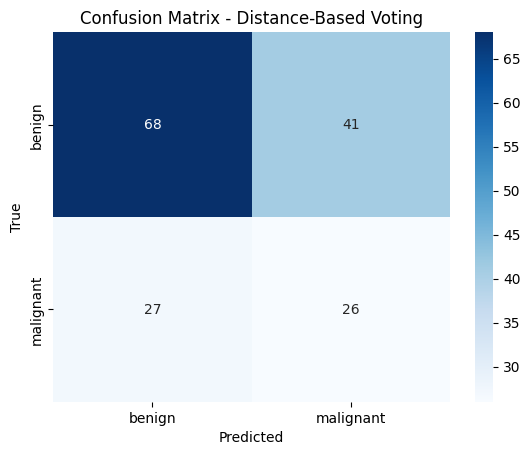

In [ ]:
cls_test = test_embeddings

# Run the classifier
y_pred_majority = classify_with_majority_voting(
    cls_test,
    tf.convert_to_tensor(kmeans_benign.cluster_centers_),
    tf.convert_to_tensor(kmeans_malignant.cluster_centers_),
    radii_benign, radii_malignant
)

# Evaluate
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("Accuracy (majority voting):", accuracy_score(y_test, y_pred_majority))

cm = confusion_matrix(y_test, y_pred_majority, labels=["benign", "malignant"])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["benign", "malignant"], yticklabels=["benign", "malignant"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Distance-Based Voting")
plt.show()

In [ ]:
TN, FP, FN, TP = cm.ravel()

total = TP + TN + FP + FN
accuracy = (TP + TN) / total if total != 0 else 0
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.5802
Precision: 0.3881
Specificity: 0.6239
Recall (Sensitivity): 0.4906
F1 Score: 0.4333


Benign cluster distribution: {10: 26, 3: 49, 11: 48, 8: 31, 0: 12, 5: 21, 2: 40, 6: 34, 7: 18, 1: 20, 4: 24, 9: 5}
Malignant cluster distribution: {7: 16, 9: 9, 2: 23, 0: 4, 11: 19, 6: 20, 3: 6, 10: 7, 5: 21, 8: 15, 1: 13, 4: 5}


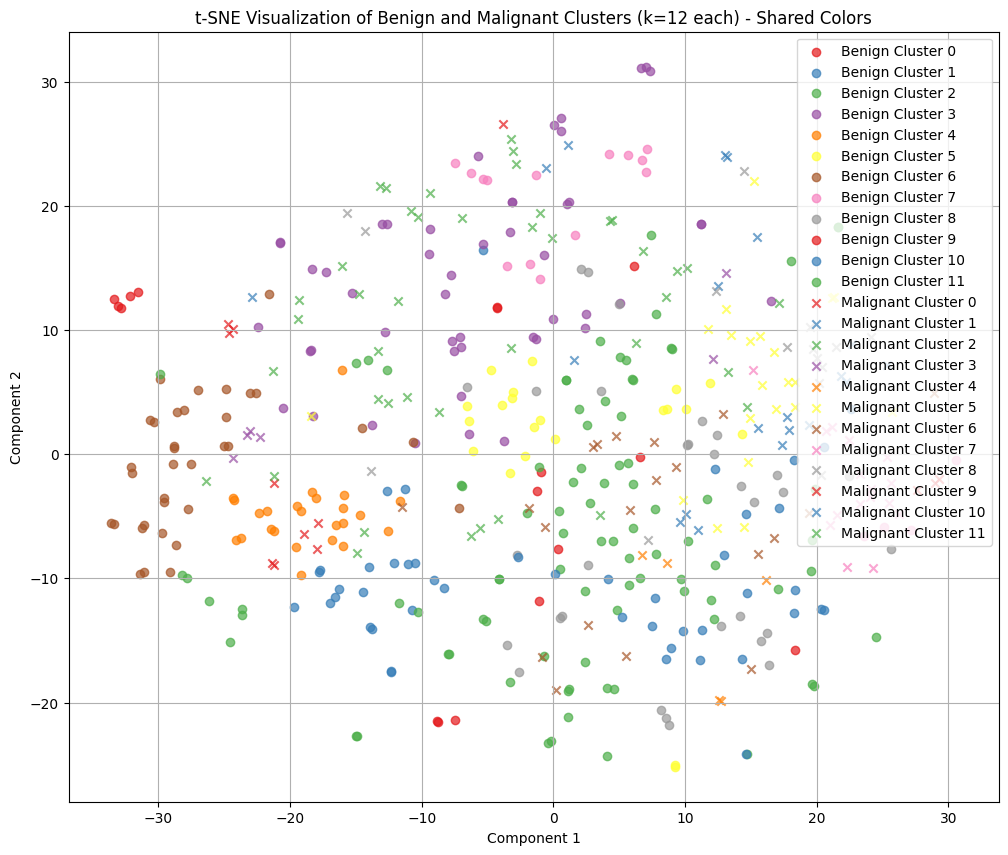

In [ ]:
# PLotting The Train Images In Their Clusters

import seaborn as sns
from collections import Counter
from sklearn.manifold import TSNE

# Print cluster counts
benign_dist = {int(k): v for k, v in Counter(labels_benign).items()}
malignant_dist = {int(k): v for k, v in Counter(labels_malignant).items()}

print("Benign cluster distribution:", benign_dist)
print("Malignant cluster distribution:", malignant_dist)

# Combine data for t-SNE
cls_combined = tf.concat([cls_class0, cls_class1], axis=0).numpy()
labels_combined = np.concatenate([labels_benign, labels_malignant])
class_flags = np.array(['benign'] * len(labels_benign) + ['malignant'] * len(labels_malignant))  # for marker

# t-SNE to reduce to 2D
cls_2d = TSNE(n_components=2, random_state=42).fit_transform(cls_combined)

# Number of clusters (k) from your model
k = len(np.unique(labels_benign))  # or `k = len(np.unique(labels_malignant))`

# Define a color palette with k colors
palette = sns.color_palette("Set1", k)  # k colors

plt.figure(figsize=(12, 10))

# Plot benign with dots, using cluster color
for cluster_id in range(k):
    idx = (class_flags == 'benign') & (labels_combined == cluster_id)
    plt.scatter(cls_2d[idx, 0], cls_2d[idx, 1],
                label=f'Benign Cluster {cluster_id}',
                alpha=0.7, marker='o', color=palette[cluster_id])

# Plot malignant with crosses, using the same cluster color
for cluster_id in range(k):
    idx = (class_flags == 'malignant') & (labels_combined == cluster_id)
    plt.scatter(cls_2d[idx, 0], cls_2d[idx, 1],
                label=f'Malignant Cluster {cluster_id}',
                alpha=0.7, marker='x', color=palette[cluster_id])

plt.title(f"t-SNE Visualization of Benign and Malignant Clusters (k={k} each) - Shared Colors")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend()
plt.grid(True)
plt.show()